# Face Verification through Siamese Network

In [1]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
import torch   
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import cv2
import sys
import time
import glob

## model structure

In [2]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layers
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        self.conv2 = nn.Conv2d(4, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3)

        # normalizing inputs
        self.batch1 = nn.BatchNorm2d(4)
        self.batch2 = nn.BatchNorm2d(16)
        self.batch3 = nn.BatchNorm2d(16)

        # padding 1x1
        self.padding = nn.ReflectionPad2d(1)
        
        # linear layers
        self.fc1 = nn.Linear(16 * 100 * 100, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500,5)
        
        # dropout layer (probability = 20%)
        self.dropout = nn.Dropout(0.20)

    def first(self, x):
        # add sequence of convolutional and normalizing layers
        x = self.batch1(F.relu(self.conv1(self.padding(x))))
        x = self.batch2(F.relu(self.conv2(self.padding(x))))
        x = self.batch3(F.relu(self.conv3(self.padding(x))))

        # flatten image input
        x = x.view(-1, 16 * 100 * 100)
        # add dropout layer
        x = self.dropout(x)
        
        # add linear levels hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def forward(self, input1, input2):
        # returning outputs for both pictures
        output1 = self.first(input1)
        output2 = self.first(input2)
        return output1, output2



## loading the model

In [3]:
model = Net()
model.load_state_dict(torch.load('model_siamese.pt',map_location='cpu'))
model.eval()

NameError: name 'Net' is not defined

In [4]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

## image input and transformation

In [8]:
filename = glob.glob('upload_here/*')
path = filename[0]
input_name = path.split("/")[-1][:-4]

def image_input(path):    
    image = cv2.imread(path)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
    )

    # find the faces in the picture and draw a rectangle arount them and cut the image 
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 0)
        roi_color = image[y:y + h, x:x + w]

        # saving the cut image
        cv2.imwrite("input/input_image/input.jpg", cv2.cvtColor(roi_color, cv2.COLOR_BGR2GRAY))

    # loadin image to for the model
    transform = transforms.Compose([transforms.Resize((100,100)),torchvision.transforms.Grayscale(num_output_channels=1),
                                    transforms.ToTensor()])
    sample1 = dset.ImageFolder("input/", transform=transform)
    input_image = DataLoader(sample1, batch_size=1)
    
    dataiter1= iter(input_image)
    img = next(dataiter1)
    
    return img[0]


## taking the image from camera and loading for the model

In [9]:
def camera_input():
    transform = transforms.Compose([transforms.Resize((100,100)),torchvision.transforms.Grayscale(num_output_channels=1),
                                        transforms.ToTensor()])
    sample2 = dset.ImageFolder("camera/", transform=transform)
    camera_image = DataLoader(sample2, batch_size=1)
    
    dataiter2= iter(camera_image)
    img = next(dataiter2)
    return img[0]

## predicting the the two images and returning the Dissimilarity score

In [17]:
def predict(img1,img2):
    with torch.no_grad():
        output1,output2 = model(img1,img2)
    euclidean_distance = F.pairwise_distance(output1, output2)
    concatenated = torch.cat((img1,img2),0).cpu()
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    
    return euclidean_distance.item()

## camera input and predicition

In [18]:
def start():
    cascPath = sys.argv[1]
    faceCascade = cv2.CascadeClassifier(cascPath)

    print("Starting")
    video_capture = cv2.VideoCapture(0)

    fontScale = 2
    thickness = 2
    text_x = 100
    text_y = 650
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_intro = "press 'c' to capture/predict and 'q' to quit"
    
    while True:
        # Capture frame-by-frame
        ret, frame = video_capture.read()

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
        faces = faceCascade.detectMultiScale(
            gray,
            scaleFactor=1.3,
            minNeighbors=3,
            minSize=(30, 30)
        )

        # Draw a rectangle around the faces
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 0)

        # Display the resulting frame
        rec_width = cv2.getTextSize(text_intro,font,fontScale-1,thickness)[0][0]
        cv2.rectangle(frame, (90,30), (rec_width+105,90), (0,0,0), cv2.FILLED)
        cv2.putText(frame,text_intro,(100,70), font, fontScale-1,(255,255,255),thickness,cv2.LINE_AA)
        cv2.imshow('Video', frame)

        key = cv2.waitKey(1)
        if key == ord('c'):
            # detecting faces from the camera image and cutting them
            roi_color = frame[y:y + h, x:x + w]
            cv2.imwrite('camera/camera_image/filename.jpg', cv2.cvtColor(roi_color, cv2.COLOR_BGR2GRAY))        

            time.sleep(2)

            # loading images and predicting
            img1 = image_input(path)
            img2 = camera_input()
            tresh = predict(img1,img2)


            if tresh<1.3:
                text = """DS {:.2f}, this is {}""".format(tresh,input_name)

            else:
                text = """DS {:.2f}, this is not {}""".format(tresh,input_name)

            rec_width = cv2.getTextSize(text,font,fontScale,thickness)[0][0]


            cv2.rectangle(frame, (text_x-10,text_y-60), (rec_width+105,text_y+20),(0,0,0), cv2.FILLED)
            cv2.putText(frame,text,(text_x,text_y), font, fontScale,(255,255,255),thickness,cv2.LINE_AA)

            cv2.imshow('result',frame)     
            time.sleep(2)
  
        elif key==ord('q'):
            break

    video_capture.release()
    cv2.destroyAllWindows()
    print("Ending")







# Let's get it working

Starting


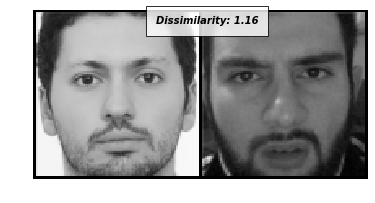

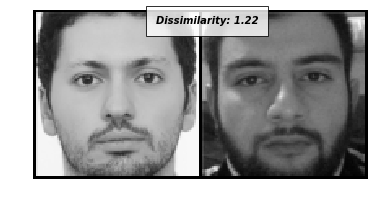

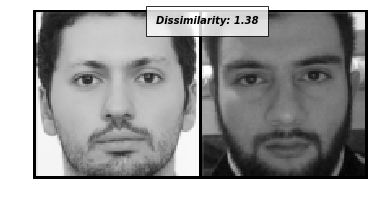

Ending


In [19]:
start()